# fvGP Single-Task Test

This is the new test for fvgp version 4.2.0 and later.

In [1]:
#!pip install fvgp==4.2.0

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP
import time


%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data

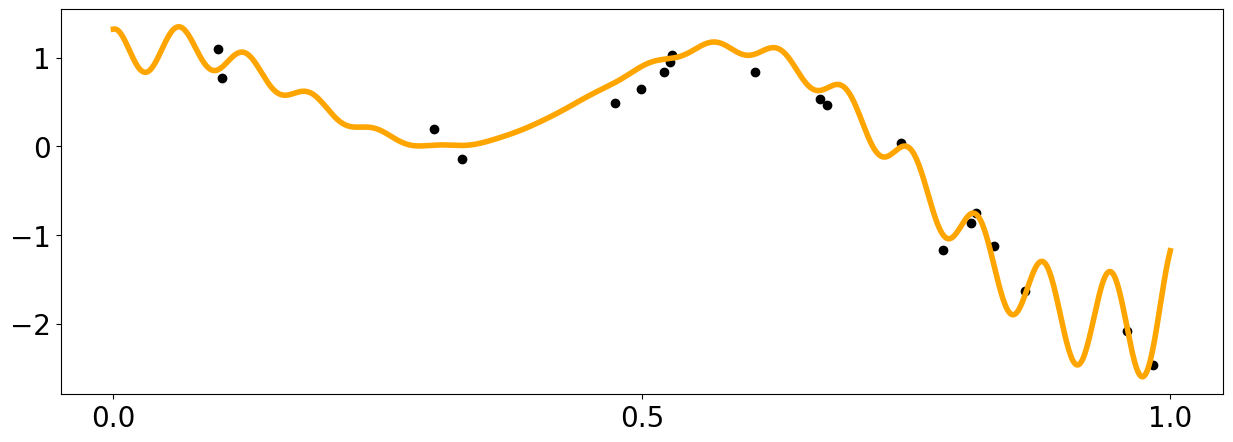

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(20).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing a Gaussian Process

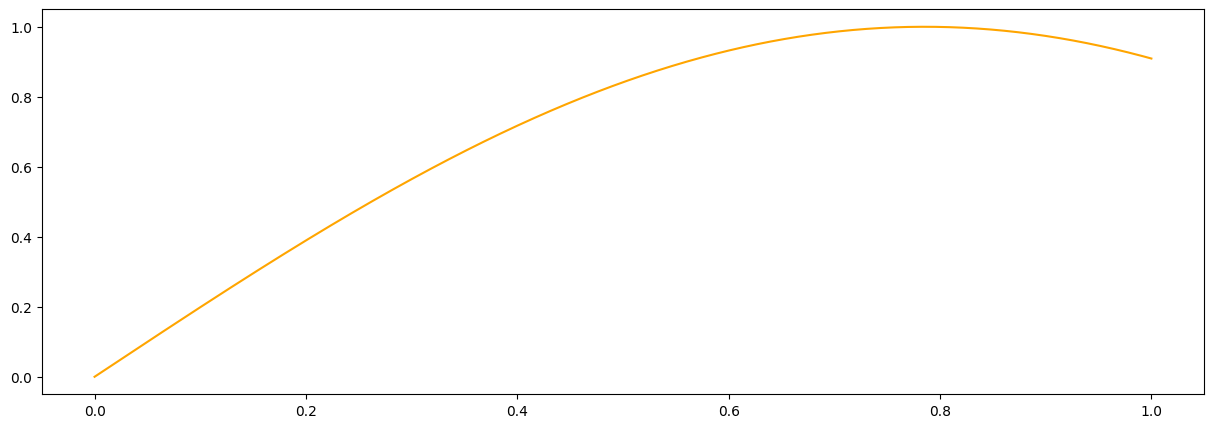

In [5]:
from fvgp.gp_kernels import *
def my_noise(x,hps,obj):
    #This is a simple noise function but can be arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.diag(np.zeros((len(x))) + hps[2])

#stationary
def skernel(x1,x2,hps,obj):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps, obj):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.]), None), color = 'orange', label = 'task1')

## Initialization and different training options

In [6]:


my_gp1 = GP(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # we need enough of those for kernel, noise and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            #hyperparameter_bounds= hps_bounds,
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            #gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )


hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.01,1.]  #mean
                      ])
my_gp1.update_gp_data(x_data, y_data, noise_variances_new=np.ones(y_data.shape) * 0.01)
print("Standard Training")
my_gp1.train(hyperparameter_bounds=hps_bounds)
print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global')
print("hps: ", my_gp1.get_hyperparameters())
print("Local Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
print(my_gp1.get_hyperparameters())
print("MCMC Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='mcmc', max_iter=1000)
print("HGDL Training")
print(my_gp1.get_hyperparameters())
my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10)


/home/marcus/Coding/fvGP/fvgp/gp.py:261: UserWarning: hyperparameter_bounds not provided. They will have to be provided in the training call.
  warnings.warn("hyperparameter_bounds not provided. "


Standard Training
Global Training
hps:  [1.32465417 0.08595755 0.03271898 0.01001098]
Local Training
[1.32465008 0.0860051  0.03271898 0.01001098]
MCMC Training
HGDL Training
[1.00494338e-02 9.14225137e+00 8.25255813e-03 5.24319320e-01]


/home/marcus/Coding/fvGP/fvgp/gp_training.py:335: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  OptimumEvaluation = minimize(
/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


### More advanced: Asynchronous training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [7]:
opt_obj = my_gp1.train_async(hyperparameter_bounds=hps_bounds)

In [8]:
#the result won't change much (or at all) since this is such a simple optimization
for i in range(10):
    time.sleep(2)
    my_gp1.update_hyperparameters(opt_obj)
    print(my_gp1.get_hyperparameters())
    print("")

/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


[1.32121898 0.08591372 0.04376501 0.01      ]

[1.32121898 0.08591372 0.04376501 0.01      ]

[1.32121898 0.08591372 0.04376501 0.01      ]

[1.32121898 0.08591372 0.04376501 0.01      ]

[1.32121898 0.08591372 0.04376501 0.01      ]

[1.32121898 0.08591372 0.04376501 0.01      ]

[1.32121898 0.08591372 0.04376501 0.01      ]

[1.32121898 0.08591372 0.04376501 0.01      ]

[1.32121898 0.08591372 0.04376501 0.01      ]

[1.32121898 0.08591372 0.04376501 0.01      ]



In [9]:
my_gp1.stop_training(opt_obj)

## The Result

1.53 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
83.2 ms ± 6.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
69 ms ± 8.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.50482130674711


/home/marcus/Coding/fvGP/fvgp/gp_posterior.py:159: UserWarning: Noise could not be added, you did not provide a noise callable at initialization
  warnings.warn("Noise could not be added, you did not provide a noise callable at initialization")


(1.028113817193425, 0.9067912229063404)


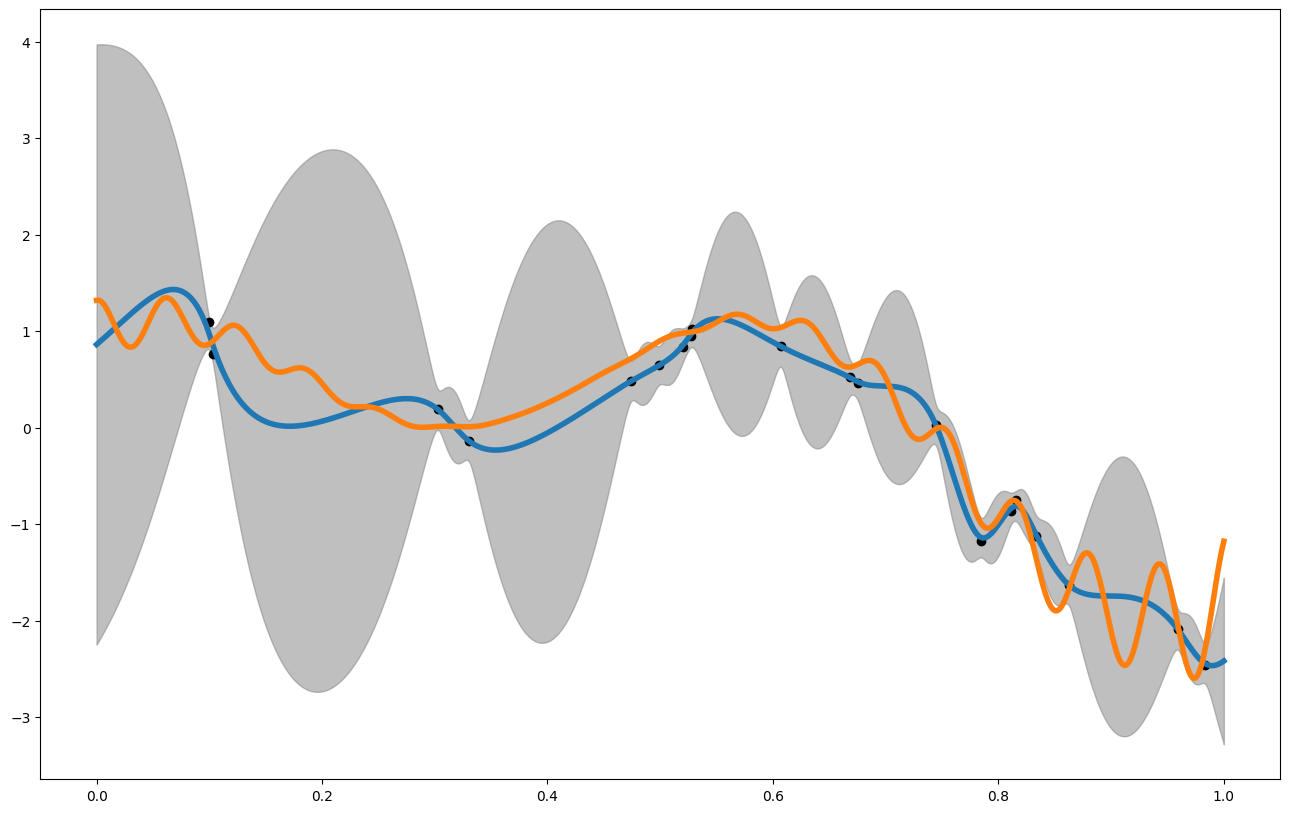

In [10]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)


%timeit mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
%timeit var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=False)["v(x)"]
%timeit var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=True, add_noise=False)["v(x)"]

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gp1.rmse(x_pred1D,f1(x_pred1D)))
print(my_gp1.crps(x_pred1D,f1(x_pred1D)))

#1.58 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
#87 ms ± 7.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

### And just for fun, we can plot how much information we are predicted to gain if we measured points across the domain

In [11]:
relative_entropy =  my_gp1.gp_relative_information_entropy_set(x_pred.reshape(-1,1))["RIE"]

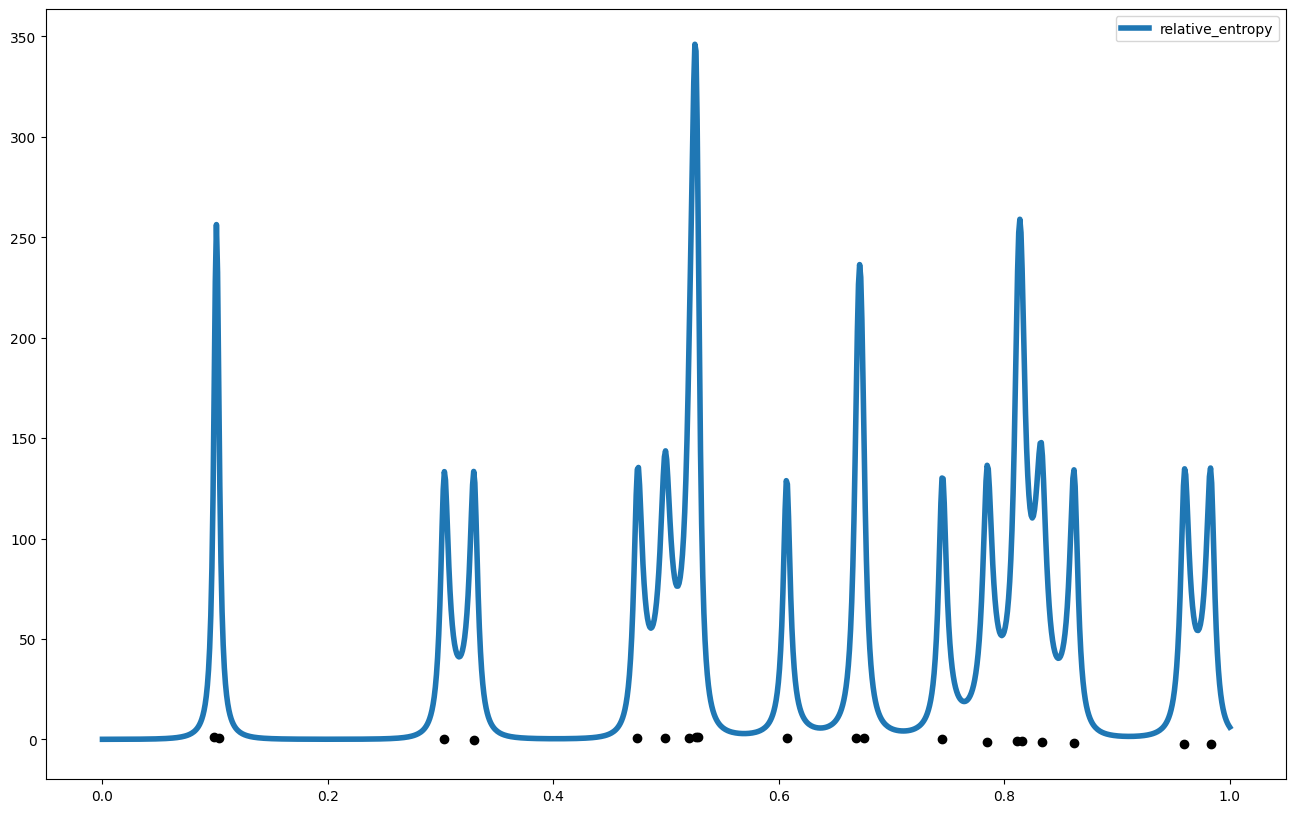

In [12]:
plt.figure(figsize = (16,10))
plt.plot(x_pred,relative_entropy, label = "relative_entropy", linewidth = 4)
plt.scatter(x_data,y_data, color = 'black')
plt.legend()

In [15]:
#We can ask mutual information and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print("MI: ",my_gp1.gp_mutual_information(x_test))
print("TC: ",my_gp1.gp_total_correlation(x_test))
my_gp1.gp_entropy(x_test)
my_gp1.gp_entropy_grad(x_test, 0)
my_gp1.gp_kl_div(x_test, np.ones((len(x_test))), np.identity((len(x_test))))
my_gp1.gp_kl_div_grad(x_test, np.ones((len(x_test))), np.identity((len(x_test))), 0)
my_gp1.gp_relative_information_entropy(x_test)
my_gp1.gp_relative_information_entropy_set(x_test)
my_gp1.posterior_covariance(x_test)
my_gp1.posterior_covariance_grad(x_test)
my_gp1.posterior_mean(x_test)
my_gp1.posterior_mean_grad(x_test)
my_gp1.posterior_probability(x_test, np.ones((len(x_test))), np.identity((len(x_test))))
my_gp1.posterior_probability_grad(x_test, np.ones((len(x_test))), np.identity((len(x_test))),0)



MI:  {'x': array([[0.45],
       [0.45]]), 'mutual information': 1.1188091321335776}
TC:  {'x': array([[0.45],
       [0.45]]), 'total correlation': 11.273145755711699}


{'probability grad': 0.9795836351314535}